Timing test suite.

In the following cell: setting up
* imports
* reading data
* defining different functions that we want to time


In [10]:
import numpy as np
invm = np.linalg.inv
import xarray as xr
from blockinv_iterative import block_iter_inv_fbm, block_iter_inv_fdm, block_iter_inv_fdi
from blockinv_iterative_symmetric import block_inv_s, block_iter_inv_s, block_iter_inv_s2


ds_1 = xr.open_dataset("data/regions_verify_isotope_202112_cov.nc")
bio_1 = ds_1["covariance_bio"]
anth_1 = ds_1["covariance_anth"]

ds_2 = xr.open_dataset("data/regions_verify_202104_cov.nc")
bio_2 = ds_2["covariance_bio"]
anth_2 = ds_2["covariance_anth"]

M = bio_2.to_numpy()

ds_sim = xr.open_dataset("simulated_data/simulation_01/init_data.nc")
print(ds_sim.cov)

<xarray.DataArray 'cov' (nstate: 2)>
array([[0.8, 0. ],
       [0. , 0.8]])
Dimensions without coordinates: nstate, nstate


Matrix inv accuracy test

In [2]:
k = int(len(M)/2)

inv1 = invm(M)
#inv2 = block_iter_inv_fdi(M, 5)
#inv3 = block_iter_inv_fdm(M, 5)
#inv4 = block_iter_inv_fbm(M, 5)
inv4 = block_iter_inv_s(M, 5)
inv5 = block_iter_inv_s2(M,5)

print(np.allclose(inv1, inv4), np.allclose(inv1, inv5))

True True


Plotting

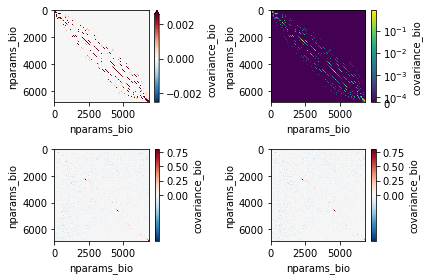

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from shifted_colormap import shiftedColorMap
# inv1 = xr.DataArray(inv1)

#orig_cmap = matplotlib.cm.coolwarm
#new_cmap = shiftedColorMap()

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2)
bio_2.plot.imshow(ax = ax0, origin = 'upper', robust = True)
bio_2.plot.imshow(ax = ax1, origin = 'upper', cmap = 'viridis',
 norm = colors.SymLogNorm(vmin = bio_2.values.min(), vmax = bio_2.values.max(), linthresh = 0.0001, linscale = 0.2))
bio_2.plot.imshow(ax = ax2, origin = 'upper', norm = colors.TwoSlopeNorm(vcenter = 0, vmin = bio_2.values.min(), vmax = bio_2.values.max()))
bio_2.plot.imshow(ax = ax3, origin = 'upper', robust = True, norm = colors.TwoSlopeNorm(vcenter = 0, vmin = bio_2.values.min(), vmax = bio_2.values.max()))
plt.tight_layout()
plt.show()

# fig, ax = plt.subplots()
# bio_2.plot.imshow(origin = 'upper',
#  norm = colors.SymLogNorm(vmin = bio_2.values.min(), vmax = bio_2.values.max(), linthresh = 0.001, linscale=0.5))
# plt.tight_layout()
# plt.show()

Timer

In [61]:
from datetime import date
print(date.today())

2022-07-28


In [6]:


# time_d = %timeit -r 7 -n 25 -o invm(M)
# time_fdi = %timeit -r 7 -n 25 -o block_iter_inv_fdi(M,5)
# time_fdm = %timeit -r 7 -n 25 -o block_iter_inv_fdm(M,5)
# time_fbm = %timeit -r 7 -n 25 -o block_iter_inv_fbm(M,5)

%timeit block_iter_inv_s2(M,5)
%timeit block_iter_inv_s(M,5)




4.41 s ± 231 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.8 s ± 2.19 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Timer results 

As far as I've understood, the timer runs -r <R> number of times and loops within each run -n <N> times, picking the minimum of those N loops.
So, to get accurate results, N should be rather large! 

BUT: FOR SOME REASON INCREASING NUMBER OF LOOPS ALSO SEEMS TO MAKE THE TIME LONGER, WHY? (e.g. s2: 7 runs 1 loop: 4.41 s ± 231 ms)

with M = bio_2.to_numpy(): 

np.linalg.inv:
* 8.57 s ± 358 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)

block_iter_inv(M,5) [with for-loop, ind assigns, calls np.linalg.inv]
* 7.42 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)

block_iter_inv(M,5) [with for-loop, multiple assign, calls np.linalg.inv] 
* 7.65 s ± 306 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)

block_iter_inv(M,5) [with for-loop, multiple assign, calls block_inv]
* 7.86 s ± 391 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)

block_iter_inv_s(M,5) [symmetric, uses transpose, with for & ind & def]
* 10.9 s ± 744 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)

block_iter_invs2(M,5) [symmetric, no transpose, with for & ind & def]
* 7.87 s ± 565 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)




Older results with 10 runs, 10 loops:

default invm: 8.54 s ± 1.48 s per loop (mean ± std. dev. of 10 runs, 10 loops each)

block_iter_inv(M,5):
    * with for-loop and block_inv: 6.79 s ± 432 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
    * with for-loop and default inv: 7.52 s ± 1.31 s per loop (mean ± std. dev. of 10 runs, 10 loops each)


block_iter_inv_w(M,5), version using while-loop and block_inv: 7.1 s ± 392 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)

In [2]:
%load_ext scalene
%scrun block_iter_inv_fdm(M)


Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [2]:
%load_ext scalene
%scrun block_iter_inv_fdi(M)

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.
